In [2]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('/Users/ethen/Business-Analytics/notebook_format')
from formats import load_style
load_style()

In [3]:
os.chdir(path)
%matplotlib inline
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# A/B Testing with Hierarchical Models

## Introduction

Imagine the following scenario: You work for a company that gets most of its online traffic through ads. Your current ads have a 3% click rate, and your boss decides that's not good enough. The marketing team comes up with 26 new ad designs, and as the company's data scientist, it's your job to determine if any of these new ads have a higher click rate than the current ad.

You set up an online experiment where internet users are shown one of the 27 possible ads (the current ad or one of the 26 new designs). After two weeks, you collect the data on each ad: How many users saw it, and how many times it was clicked on.

Time to run some statistical tests! New design A vs current design? No statistically significant difference. New design B vs current design? No statistically significant difference. You keep running test and continue getting not significant results. Just as you are about lose hope, new design Z v. current design.... Statically significant difference at the alpha = 0.05 level!

You tell your boss you've found a design that has a higher click rate than the current design, and your company deploys it in production. However, after two months of collecting statistics on the new design, it seems the new design has a click rate of 3%. What went wrong?

When performing A/B testing, data scientists often fall into the common pitfall of failing to correct to for multiple testing. Testing at alpha = 0.05 means your statistical test yielding a result as extreme or more extreme by random chance (assuming a given null hypothesis is true) occurs with probability 0.05. If you run 26 statistical tests, then an upper bound on the expected number of false positives is 26*0.05 = 1.3. This means in our above scenario, our data scientist can expect to have at least one false positive result, and unfortunately, the false positive result is the one she reported to her boss.

## The Bernoulli Model

Let's first look at how we would perform A/B Testing in the standard two website case with Bernoulli models. Recall from above, website A had 1055 clicks and 27 sign-ups, and website B had 1057 clicks and 45 sign-ups.

In [4]:
# Website A had 1055 clicks and 28 sign-ups
# Website B had 1057 clicks and 45 sign-ups
values_A = np.hstack( ( [0] * (1055 - 28), [1] * 28 ) )  
values_B = np.hstack( ( [0] * (1057 - 45), [1] * 45 ) )
print(values_A)
print(values_B)

[0 0 0 ..., 1 1 1]
[0 0 0 ..., 1 1 1]


Now, we can model each possible sign-up as a Bernoulli event. Recall the Bernoulli distribution reflects the outcome of a coin flip. With some probability $p$, the coin flips head and with probability $1-p$, the coin flips tails. The intuition behind this model is as follows: A user visits the website. The user flips a coin. If coin lands head, the user signs up.

Now, let's say each website has its own coin. Website A has a coin that lands heads with probability $p(A)$, and Website $p(B)$ has a coin that lands heads with probability $p(B)$. We don't know either probabilities, but we want to determine if $p(A)$ < $p(B)$ or if the reverse is true (There is also the possibility that $p(A)$ = $p(B)$).

Since we have no information or bias about the true values of $p(A)$ or $p(B)$, we will draw these two parameters from a Uniform distribution. In addition, I've created a delta function to create the posterior distribution for the difference of the two distributions. Remember the difference between the two probabilities is what we're interested in.

In [5]:
# Create a uniform prior for the probabilities p_a and p_b
p_A = pm.Uniform( 'p_A', lower = 0, upper = 1 )  
p_B = pm.Uniform( 'p_B', lower = 0, upper = 1 )

# Creates a posterior distribution of B - A
@pm.deterministic
def delta( p_A = p_A, p_B = p_B ):  
    return p_B - p_A

Notes on the code above:

- For the `pm.Uniform()` section: These are **stochastics variables**, variables that are random. Initializing a **stochastic variable** requires a name argument, plus additional parameters that are class specific. The first attribute is the name attribute, which is used to retrieve the posterior distribution later in the analysis, so it is best to use a descriptive name. Typically, you can use the Python variable's name as the name. Here, the later two attribute is simply the lower and upper bound for the uniform distribution.
- For the **deterministic variables** are variables that are not random if the variables' *parents* were known, here if I knew all the value of `delta`'s *parent*, `p_A` and `p_B`, then I could determine what `delta` is. We distinguish **deterministic variables** with a `pm.deterministic` decorator wrapper.

---

Next, we will create an observations variable for each website that incorporates the sign-up data for each website. Thus we create a Bernoulli **stochastic variable** with our prior and values.

In [6]:
# Create the Bernoulli variables for the observation
obs_A = pm.Bernoulli( 'obs_A', p_A, value = values_A, observed = True )  
obs_B = pm.Bernoulli( 'obs_B', p_B, value = values_B, observed = True )

# Create the model and run the sampling
# Sample 50,000 points and throw out the first 10,000
model = pm.Model( [ p_A, p_B, delta, obs_A, obs_B ] )  
mcmc  = pm.MCMC(model)
mcmc.sample( 50000, burn = 10000 ) 

 [-----------------100%-----------------] 50000 of 50000 complete in 4.3 sec

Notes on the code above:

- **stochastic variables** have a keyword argument `observed` which accepts a boolean (False by default). The keyword `observed` has a very simple role: fix the variable's current value, i.e. make value immutable. We have to specify an initial value in the variable's creation, equal to the observations we wish to include, typically an array (and it should be an numpy array for speed).
- We can wrap all the created variables into a `pm.Model` class. With this Model class, we can analyze the variables as a single unit. This is an optional step, as the fitting algorithms can be sent an array of the variables rather than a Model class. So for the code above, you can do `mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])` instead of having to call `pm.Model ...` and then `pm.MCMC`.

---

Now, let' examine the posterior of the delta distribution (Remember, this is the posterior of Website B - posterior of Website A).

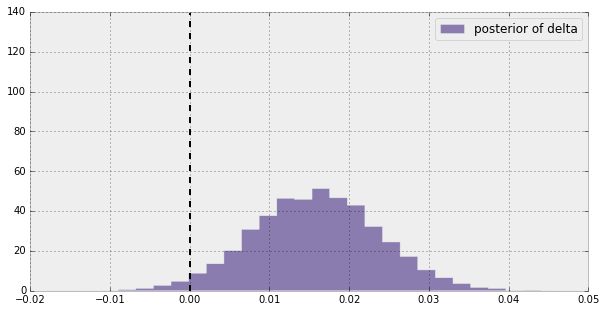

In [28]:
delta_samples = mcmc.trace("delta")[:]

plt.figure( figsize = ( 10, 5 ) )
plt.hist( delta_samples, histtype = 'stepfilled', bins = 30, alpha = 0.85,
          label = "posterior of delta", color = "#7A68A6", normed = True)
plt.vlines( x = 0.0, ymin = 0, ymax = 140, color = "black", linestyle = "--" )
plt.legend(loc = "upper right")
plt.show()

The black line is at x = 0, representing where the difference between the two distributions is 0. From inspection, we see that most of the distribution's mass is to the right of the black line. This means most of the points sampled from B's distribution are larger than those sampled from A's distribution, implying that site B's response is likely better than site A's response. To get more quantitative results, we can compute the probability that website B gets more sign-ups than website A by simply counting the number of samples less than 0, i.e. the area under the curve before 0, 
represent the probability that site B is worse than site A.

In [8]:
print( "Probability site B is WORSE than site A: %.3f"  % ( delta_samples < 0 ).mean() )
print( "Probability site B is BETTER than site A: %.3f" % ( delta_samples > 0 ).mean() )

Probability site B is WORSE than site A: 0.022
Probability site B is BETTER than site A: 0.978


For these two websites, we see that website B outperforms website A. This worked well for two websites, but if you're modeling an A/B test with several variants ( e.g. an A/B/C/D test ), you should use a hierarchical Beta-Binomial model to:

- Protect yourself from a variety of multiple-comparison-type errors.
- Get ahold of posterior distributions for your true conversion rates.

We'll talk about hierarchical models in a moment, but I first want to explain the sort of multiple comparison errors we're trying to avoid. Here's an exaggerated example: 

Suppose that we have a single coin. We flip it 100 times, and it lands heads up on all 100 of them; how likely do you think it is that the coin is fair (i.e has a 50/50 chance of landing heads up)? Pretty slim; The probability of observing 100 heads out of 100 flips of a fair coin is: 

$$1/2^{100} \approx 7.9×10^{−31}$$

Now imagine a new scenario: Instead of just one coin, we now have $2^{100}$ of them. We flip each 100 times. I notice that one of the $2^{100}$ coins has landed heads up on all 100 of its flips; how likely do you think it is that this coin is fair? A full answer will take us into hierarchical modeling, but at this point it's already clear that we need to pay attention to the fact that there were another $2^{100} - 1$ coins: Even if all the $2^{100}$ coins were fair, the probability that at least one of them lands heads up on all 100 flips is:

$$1 − \left( 1 − \frac{1}{2^{100}} \right)^{2^{100}} \approx 1 − \frac{1}{e} \approx 63.2%$$

Back to the website example, if we tried this for all pairs of our five websites, we run the risk of getting a "false positive problem" due to the multiple testing problem. There are 10 possible pairs, so assume we test all possible pairs independently at an alpha = 0.05 level. For each test, we have a 95% chance of not getting a false positive, so the probability that all the tests do not yield a false positive is $0.95^{10}$, which is roughly equal to 0.60. This means the probability of getting at least one false positive result is about 0.40 or 40%. If we had more websites and thus more pairs to test, the probability of getting a false positive would only increase.

As you can see, without correcting for multiple testing, we run a high risk of encountering a false positive result.

## Beta Distribution and Bayesian Priors

Before I introduce the Beta-Binomial hierarchical model, I want to discuss the theoretical motivation for the Beta distribution. Let's consider the Uniform Distribution over the interval (0,1).

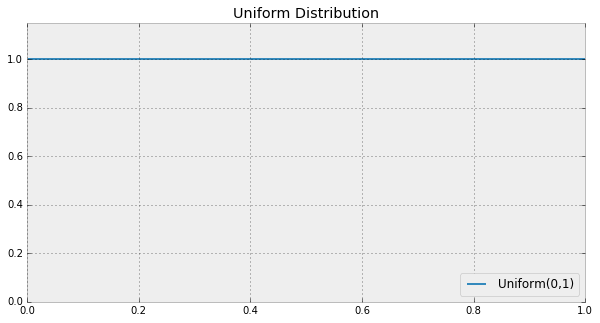

In [29]:
support = np.linspace( 0, 1, num = 500 )
dunif = stats.uniform().pdf(support)

plt.figure( figsize = ( 10, 5 ) )
plt.plot( support, dunif, label = "Uniform(0,1)" )
plt.ylim( 0, 1.15 )
plt.legend( loc = "lower right" )
plt.title("Uniform Distribution")
plt.show()

# replace .show() with .savefig to save the pics and also shows the plot
# plt.savefig("Uniform.png", format="png")

As you can see, it's a simple distribution. It assigns equal probability weight to all points in the domain (0,1), also known as the support of the distribution. However, what if we want a distribution over (0,1) that isn't just flat everywhere?

This is where the Beta distribution comes in! The Beta distribution can be seen as a generalization of the Uniform(0,1) as it allows us to define more general probability density functions over the interval (0,1). Using two parameters a and b, the Beta(a,b) distribution is defined with the following probability density function:

$$pdf(x) = C x^{\alpha - 1} (1 - x)^{\beta - 1}, x \in (0, 1), \alpha, \beta > 0$$

Where C is a constant to normalize the integral of the function to 1 (all probability density functions must integrate to 1). This constant is formally known as the Beta Function.

But the important thing is that by changing the values of a and b, we can change the shape and the "steepness" of the distribution, thus allowing us to easily create a wide variety of functions over the interval (0,1).

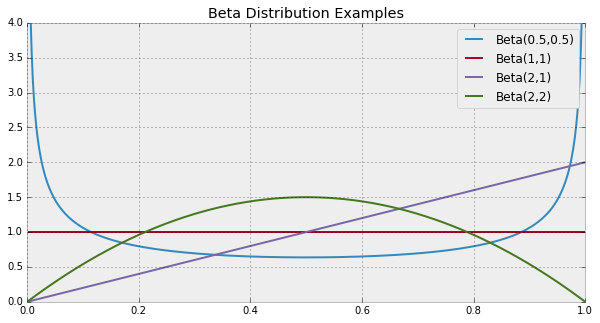

In [31]:
a_vals = ( 0.5, 1, 2, 2 )
b_vals = ( 0.5, 1, 1, 2 )

plt.figure( figsize = ( 10, 5 ) )
for a, b in zip( a_vals, b_vals ):
    plt.plot( support, stats.beta( a, b ).pdf(support), label = "Beta(%s,%s)" % ( a, b ) )
plt.legend()
plt.ylim( 0,4 )
plt.title("Beta Distribution Examples")
plt.show()

Notice in the above plot that the green line corresponding to the distribution Beta(1,1) is the same as that of Uniform(0,1), proving that the Beta distribution is indeed a generalization of the Uniform(0,1).

Now, I'm sure many of you are wondering what's the big takeaway from this section, so here they are:

- The Beta Distribution is a versatile family of probability distributions over (0,1). 
- This allows us to create prior distributions that incorporate some of our beliefs and thus informative priors. More concretely, when you have a k-successes-out-of-n-trials-type test, you can use the Beta distribution to model your posterior distributions. If you have test with k success amongst n trials, your posterior distribution is $Beta(k+1,n−k+1)$.

In the next section, I will discuss why this is important, and how the Beta Distribution can be used for A/B testing.

## Hierarchical Models

So how do "hierarchical models" solve this problem? They model all of the test buckets at once, rather than treating each in isolation. More specifically, they use the observed rates of each bucket to infer a prior distribution for the true rates; these priors then influences the predicted rates by "shrinking" posterior distributions towards the prior.

Let's work our way up to this idea. First, let's say that we flip a coin 100 times and that it lands heads-up on 60 of them. We model this as $p \sim Beta(61,41)$, and our posterior distribution looks like this:

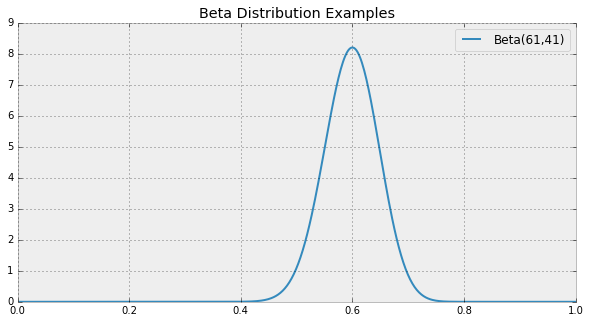

In [37]:
plt.figure( figsize = ( 10, 5 ) )
plt.plot( support, stats.beta( 61, 41 ).pdf(support), label = "Beta(%s,%s)" % ( 61, 41 ) )
plt.legend()
plt.title("Coin Flips")
plt.show()

Aside: There is a handy general rule here. If your prior is $p \sim Beta(a,b) and you observe X=k for X∼Bin(n,p)X∼Bin(n,p), then your posterior is (p∣X)∼Beta(a+k,b+n−k)(p∣X)∼Beta(a+k,b+n−k). Beta is a "conjugate prior" for Bin, meaning that the posterior is also Beta.) 

Second, let's suppose, unrealistically, that we have an explicit prior distribution. We've flipped a lot of similar coins in the past, and we're pretty sure that the true bias of such coins follows a Beta(51,51) distribution. Applying Bayes' rule with this prior, we would now model our observation of 60 out of 100 heads-up as $p \sim Beta(112,92)$. 

Now our posterior distribution looks as follows. We keep the original for reference:

In [ ]:
a_vals = ( 0.5, 1, 2, 2 )
b_vals = ( 0.5, 1, 1, 2 )

plt.figure( figsize = ( 10, 5 ) )
for a, b in zip( a_vals, b_vals ):
    plt.plot( support, stats.beta( a, b ).pdf(support), label = "Beta(%s,%s)" % ( a, b ) )
plt.legend()
plt.ylim( 0,4 )
plt.title("Beta Distribution Examples")
plt.show()

## Reference

1. [A/B Testing with Hierarchical Models in Python](http://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/)
2. [Bayesian Statistics for Hackers Chapter 2](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Chapter2.ipynb)
3. [Stastical Advice for A/B Testing](http://sl8r000.github.io/ab_testing_statistics/)